# Class definition

This class is to make a good way of having a large sample of stars and alternate between the dataframe or the tensor so that can easily homogenise the algorithms

In [1]:
import os
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch

/var/folders/v8/qszwt8g90wj00vpb5s08vpdw0000gn/T/ipykernel_80201/941303352.py:3: DtypeWarning: Columns (11,12,15,16,17,18) have mixed types. Specify dtype option on import or set low_memory=False.
  cluster_df=pd.read_csv('cluster_members_final.csv')


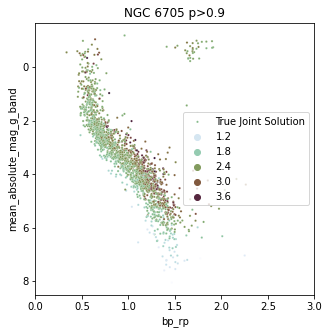

In [2]:
# Data input, take in the cluster and plot the memebrs
os.chdir("Data")
cluster_df=pd.read_csv('cluster_members_final.csv')
os.chdir("../")


probability='p3'
f, axes = plt.subplots(1, 1)
f.set_figheight(5)
f.set_figwidth(5)

cluster_df=cluster_df[cluster_df['phot_bp_mean_flux_error']<1000].reset_index(drop=True)

scatter=cluster_df[cluster_df[probability]>0.9]


sn.scatterplot(x=scatter['bp_rp'],y=scatter['mean_absolute_mag_g_band'],hue=scatter['rgeo'],s=5,ax=axes,label='True Joint Solution',color='b', palette="ch:r=1,l=1.0")
axes.invert_yaxis()
plt.legend()
axes.set_title("NGC 6705 p>0.9")
plt.xlim(0,3)
plt.show()


scatter=scatter[scatter['rgeo']>=1.8].reset_index(drop=True)
scatter=scatter[scatter['rgeo']<=2.5].reset_index(drop=True)
#scatter=scatter[scatter['bp_rp']<=1.6].reset_index(drop=True)

orig_scatter=scatter

orig_scatter['rgeo']=scatter['rgeo'].median() #still assuming everything at the same distance
#set the main distance.
orig_scatter['rgeo']=2.0

cluster_df=scatter

In [3]:
x_input=cluster_df[['ra','dec','parallax','phot_g_mean_mag','bp_rp']]
x_input_err=cluster_df[['ra_error','dec_error','parallax_error','phot_g_mean_mag_error','bp_rp_error']]

KeyError: "['phot_g_mean_mag_error', 'bp_rp_error'] not in index"

We are assuming now that cluster df is the data we would be normally inputting. We will assume that the input is columns of data in a pandas dataframe one of which is the normal and the other of which is the error

In [ ]:
class StarSample:
    def __init__(self,input_dataframe, input_error_dataframe):
        if(type(input_dataframe)==pd.DataFrame and (len(input_error_dataframe)==len(input_dataframe))):
            self.data=input_dataframe
            self.data_columns=input_dataframe.columns
            self.error=input_error_dataframe
            self.error_columns=input_error_dataframe.columns
            self.resampled=None
            self.dropna=False

            try:
                self.error['phot_g_mean_mag_error']=np.sqrt(((2.5/np.log(10))*self.error['phot_g_mean_flux_error']/self.data['phot_g_mean_flux'])**2+0.0027553202**2)
                self.error['bp_error']=np.sqrt(((2.5/np.log(10))*self.error['phot_bp_mean_flux_error']/self.data['phot_bp_mean_flux'])**2+0.0037793818**2)
                self.error['rp_error']=np.sqrt(((2.5/np.log(10))*self.error['phot_rp_mean_flux_error']/self.data['phot_rp_mean_flux'])**2+0.0027901700**2)
                self.error['bp_rp_error']=np.sqrt(self.error['rp_error']**2+self.error['bp_error']**2)
                self.error_columns=self.error.columns
            except:
                print('Some Gaia parameters not available')    

        else:
            raise NotImplemented

    def dropna(self):
        x=pd.concat([self.data,self.error],axis=1).dropna().reset_index(drop=True)
        self.data=x[self.data_columns]
        self.error=x[self.error_columns]
        self.dropna=True

    def cut_on_condition(self,condition,column,val):
        x=pd.concat([self.data,self.error],axis=1)
        if(condition=='ge'):
            x=x[x[column]>=val].reset_index(drop=True)
        elif(condition=='le'):
            x=x[x[column]<=val].reset_index(drop=True)
        self.data=x[self.data_columns]
        self.error=x[self.error_columns]
        

    def full_dataframe(self,dropna=False):
        if(dropna==False):
            return pd.concat([self.data,self.error],axis=1)
        else:
            return pd.concat([self.data,self.error],axis=1).dropna().reset_index(drop=True)

    def to_tensor(self,expand=True,expandsize=1):
        x_values=self.full_dataframe(self).values
        x_values=torch.tensor(x_values)          
        if(expand==True):     
            x_values=x_values.reshape((x_values.shape[0],x_values.shape[1],1))
            import torch.nn.functional as F
            pad_size=np.max(expandsize)
            x_values=x_values.expand(x_values.shape[0],x_values.shape[1],pad_size)
        return x_values


    def mean_absolute_mag_g_band(self,abs_column_name,magnitude_column,parallax_column):
        self.data[abs_column_name] = self.data[magnitude_column].values+5*np.log10(self.data[parallax_column].values/1000)+5
   
    def resample(self,draw_size,input_columns,error_columns,store=False):
        mean_x=self.data[input_columns].to_numpy()
        var_x=self.error[error_columns].to_numpy()**2
        x_params=[]
        x_var=[]
        draw_size=32 
        for i in range (len(mean_x)):
            mu=mean_x[i]
            sig=np.diag(var_x[i])
            draws = np.random.multivariate_normal(mu, sig, size=draw_size)

            x_params.append(draws)
            x_var.append(np.tile(sig,(draw_size,1)))
        x_params=np.array(x_params)
        x_params=x_params.reshape((x_params.shape[0]*x_params.shape[1],x_params.shape[2]))

        x_var=np.array(x_var)
        x_var=x_var.reshape((x_var.shape[0]*x_var.shape[1],x_var.shape[2]))

        resampled_x=pd.DataFrame(data=x_params,columns=[input_columns])
        resampled_err=pd.DataFrame(data=x_params,columns=[error_columns])
        if(store==True):
            self.resampled=pd.concat([resampled_x,resampled_err],axis=1)
        return pd.concat([resampled_x,resampled_err],axis=1)

    def save_dataframe(self,full=True):
        if(full==True):
            self.full_dataframe(self).to_csv('star_sample_full')
        else:
            raise NotImplemented

    def hr_plot(self,title,mag_column,colour_column,hue_column,height=10,width=10,**kwargs):
        f, axes = plt.subplots(1, 1)
        f.set_figheight(height)
        f.set_figwidth(width)
        sn.scatterplot(x=cluster_df[colour_column],y=cluster_df[mag_column],hue=cluster_df[hue_column],kwargs=kwargs)
        axes.invert_yaxis()
        plt.legend()
        axes.set_title(title)
        plt.xlim(0,3)
        plt.show()

    
        

: 

In [ ]:
import minimint

class Isochrones:
    def __init__(self,filters,logagegrid,massgrid,fehgrid,phase=0):
        ii = minimint.Interpolator(filters)
        self.isochrones_list=[]
        self.pad_size=None
        for feh in fehgrid:
            for lage in logagegrid:
                iso = pd.DataFrame(ii(massgrid, lage, feh))
                self.isochrones_list.append(iso[iso['phase']==0].reset_index(drop=True))

        

    def plot_isochrones(self, index=None):
        fig = plt.figure(figsize=(6, 6), dpi=120)
        if(index==None):
            for isochrone in self.isochrones_list:
                plt.plot(isochrone['Gaia_BP_EDR3']-isochrone['Gaia_RP_EDR3'], isochrone['Gaia_G_EDR3'],
                                )
        else:
            isochrone=self.isochrones_list[index]
            plt.scatter(isochrone['Gaia_BP_EDR3']-isochrone['Gaia_RP_EDR3'], isochrone['Gaia_G_EDR3'],
                                )

            
        plt.title('Plot of isochrones')
        plt.ylim(20, -15)

    
    def slopes_creator(self):
        for isochrone in self.isochrones_list:
            p_slopes=[]
            isochrone['BPRP']=isochrone['Gaia_BP_EDR3']-isochrone['Gaia_RP_EDR3']
            x=isochrone['BPRP']
            y=isochrone['Gaia_G_EDR3']
            
            for i in range(len(isochrone)-1):    
                dy=y[i+1]-y[i]
                dx=x[i+1]-x[i]
                p_slopes.append(-1*dx/dy)
            p_slopes.append(0)

            isochrone['p_slopes']=p_slopes
            isochrone['slopes']=-1/isochrone['p_slopes']

            high_c=[]
            low_c=[]
            for i in range(len(isochrone)-1):
                high_c.append(isochrone['Gaia_G_EDR3'][i+1] - isochrone['p_slopes'][i]*isochrone['BPRP'][i+1])
                low_c.append(isochrone['Gaia_G_EDR3'][i] - isochrone['p_slopes'][i]*isochrone['BPRP'][i])
            high_c.append(0)
            low_c.append(0)
            isochrone['low_c']=high_c #high c is low c oops
            isochrone['high_c']=low_c
            isochrone=isochrone[:-2]
    
    def stack_isochrones(self,pad_size):
        tens=[]
        lengths=[]
        
        for isochrone in self.isochrones_list:
            isoc=torch.tensor(isochrone.values).reshape((1,isochrone.shape[1],isochrone.shape[0]))
            tens.append(isoc)
            lengths.append(isoc.shape[-1])
            stack_tens=[]
        import torch.nn.functional as F
        self.pad_size=np.max(lengths)
        for i in range(len(tens)):
            t=F.pad(input=tens[i], pad=(0,self.pad_size-tens[i].shape[-1]), value=torch.nan)
            stack_tens.append(t.reshape(t.shape[1:]))
        return torch.stack(stack_tens)